<a href="https://colab.research.google.com/github/Ramjeet-Dixit/IITM-AIML-Rdixit/blob/main/Keras_Tuner_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q -U keras-tuner


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!install --upgrade pip

install: illegal option -- -
usage: install [-bCcpSsUv] [-f flags] [-g group] [-m mode] [-o owner]
               [-M log] [-D dest] [-h hash] [-T tags]
               [-B suffix] [-l linkflags] [-N dbdir]
               file1 file2
       install [-bCcpSsUv] [-f flags] [-g group] [-m mode] [-o owner]
               [-M log] [-D dest] [-h hash] [-T tags]
               [-B suffix] [-l linkflags] [-N dbdir]
               file1 ... fileN directory
       install -dU [-vU] [-g group] [-m mode] [-N dbdir] [-o owner]
               [-M log] [-D dest] [-h hash] [-T tags]
               directory ...


In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical #np_utils updated to to_categorical
from keras_tuner.tuners import RandomSearch #randomsearch instead of hyperband


# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize the images to a 0 to 1 range
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train.shape

(50000, 32, 32, 3)

In a CNN, convolutional layer accepts images in 3 dimension

fashion mnist data, 2D, width x height

add a third dimension, depth (color channel)

from 28x28 to 28x28x1..60000, 28,28,1

In [7]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
# Reshape dataset to have a single channel
#x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
#x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

In [8]:
#x_train.shape

In [9]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [ ]:
len(y_train)

50000

For instance, if there are 10 classes, the class label 2 would be represented as [0, 0, 1, 0, 0, 0, 0, 0, 0, 0].

In [10]:
# Convert class vectors to binary class matrices
#required only if categorcial crossentropy method is used, not with sparse method
y_train = to_categorical(y_train, 10) #60000 labels
y_test = to_categorical(y_test, 10) #10000 labels

In [11]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [12]:
from keras.layers import BatchNormalization

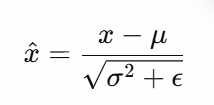

batchnormalisation

it works by rescaling the outputs of a layers so they stay in a healthy range (0 to 1) instead of becoming too large or too small

keeps the layer's output nicelty centred and scaled

adjusting exam scores of every class has mean 0 and stdev 1 before fuurther grading

Step 1: Compute batch statistics

For current batch:

calculates the mean: batch mean

calculates the variance: batch variance

Step 2: Normalization

x_normalised = (x -  mean) /stdev

now the values, mean 0 and stdev 1

Step 3: Learnable scale + shift

Batch norm adds two trainable parameters

1. gamma - scale

2. beta - shift

output = gamma * x_normalised + beta --  Why?

because may be mean 0 and stdev 1 might not be ideal..the network can learn the best scale and offset accordingly

During inference (testing)

at the testing, no batch to compute mean and variance

so batchnorm uses:

1. running average of mean

2. running average of variance

Momemtum: Memory of the past

keeps a running estimate of the mean and the variance

which are later used for testing.

Momemtum decides how fast these running estimate  values update

how much trust past batches vs the current batch

example: momemtum 0.9

new_running_mean = 0.9 * old_running_mean + 0.1 x current_batch_mean

In [14]:
def build_model(hp):
    model = Sequential() #instantiate the sequential method
    model.add(Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                     kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
                     activation='relu',
                     input_shape=(32,32,3)))
    # Add batch normalization with tunable momentum and epsilon
    model.add(BatchNormalization(
        momentum=hp.Float('bn_momentum', min_value=0.8, max_value=0.99, step=0.05),
        epsilon=hp.Float('bn_epsilon', min_value=1e-5, max_value=1e-3, step=1e-5)
    ))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
                     kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
                     activation='relu'))
    model.add(BatchNormalization(
        momentum=hp.Float('bn_momentum_2', min_value=0.8, max_value=0.99, step=0.05),
        epsilon=hp.Float('bn_epsilon_2', min_value=1e-5, max_value=1e-3, step=1e-5)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

#ANN
    model.add(Flatten()) #input layer
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
                    activation='relu')) #hidden layers
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(10, activation='softmax')) #output layer

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [15]:
# Setup Keras Tuner
tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=5,
                     executions_per_trial=3,
                     directory='output',
                     project_name='FashionMNIST',
                     overwrite=True)

2026-02-14 16:26:26.748530: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2026-02-14 16:26:26.748654: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-02-14 16:26:26.748661: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-02-14 16:26:26.748750: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-14 16:26:26.748784: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


PermissionDeniedError: output; Read-only file system

In [ ]:
#early stopping to overcome the overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(x_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

Trial 5 Complete [00h 03m 29s]
val_accuracy: 0.6432333191235861

Best val_accuracy So Far: 0.7048999865849813
Total elapsed time: 00h 16m 47s


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
#number of units in the hidden layer
#learning rate

#num_trials: Optional number of HyperParameters objects to return.

#Returns
#List of HyperParameter objects sorted from the best to the worst.

In [ ]:

print(best_hps.get('conv_1_filter'))
print(best_hps.get('conv_1_kernel'))
print(best_hps.get('conv_2_filter'))
print(best_hps.get('conv_2_kernel'))
print(best_hps.get('dense_units'))
print(best_hps.get('learning_rate'))
print(best_hps.get('dropout_rate'))

96
3
48
5
96
0.001
0.2


In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
newmodel = model.fit(x_train, y_train, epochs=50, validation_split=0.2)
newmodel

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.3967 - loss: 1.7447 - val_accuracy: 0.5262 - val_loss: 1.3067
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5810 - loss: 1.1831 - val_accuracy: 0.5177 - val_loss: 1.3652
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6569 - loss: 0.9840 - val_accuracy: 0.6383 - val_loss: 1.0469
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6970 - loss: 0.8678 - val_accuracy: 0.6526 - val_loss: 1.0568
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.7220 - loss: 0.7812 - val_accuracy: 0.6865 - val_loss: 0.9232
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7496 - loss: 0.7051 - val_accuracy: 0.6576 - val_loss: 1.0001
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7792 - loss: 0.6284 - val_accuracy: 0.7180 - val_loss: 0.8380
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7932 - loss: 0.5820 

In [ ]:

val_acc_per_epoch = newmodel.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 21


In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_split=0.2)

Epoch 1/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.4001 - loss: 1.7265 - val_accuracy: 0.4937 - val_loss: 1.3949
Epoch 2/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5906 - loss: 1.1652 - val_accuracy: 0.6031 - val_loss: 1.1039
Epoch 3/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6519 - loss: 0.9906 - val_accuracy: 0.6500 - val_loss: 1.0047
Epoch 4/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6943 - loss: 0.8724 - val_accuracy: 0.6052 - val_loss: 1.1625
Epoch 5/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7301 - loss: 0.7724 - val_accuracy: 0.6554 - val_loss: 0.9778
Epoch 6/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7485 - loss: 0.7060 - val_accuracy: 0.6258 - val_loss: 1.0843
Epoch 7/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7716 - loss: 0.6456 - val_accuracy: 0.6977 - val_loss: 0.9689
Epoch 8/21
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.7941 - loss: 0.5835 

In [ ]:
eval_result = hypermodel.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6957 - loss: 1.1930
[test loss, test accuracy]: [1.2085222005844116, 0.6969000101089478]


In [ ]:
eval_result = hypermodel.evaluate(x_train, y_train)
print("[train loss, train accuracy]:", eval_result)

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9468 - loss: 0.1718
[train loss, train accuracy]: [0.35883063077926636, 0.902679979801178]


# Setup Hyperband tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='output',
    project_name='FashionMNIST_Hyperband',
    overwrite=True
)

#early stopping to overcome the overfitting
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
#skipping on early stopping for this example
tuner.search(x_train, y_train, epochs=10, validation_split=0.2)

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)

#skipped the tuning of no of epochs
newmodel = model.fit(x_train, y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = newmodel.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_split=0.2)

In [ ]:

# Evaluate the best model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_accuracy}, Test loss: {test_loss}')